In [ ]:
import librosa
import numpy as np
import pandas as pd

In [ ]:
def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  #feat_names = ['{}_{}'.format(feat,summary) for feat in feat_names for summary in summary_names]
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  return summary_features, feat_names  

In [ ]:
from google.colab import files

!rm /content/*.wav
uploaded = files.upload()

rm: cannot remove '/content/*.wav': No such file or directory


Saving ventilador.wav to ventilador.wav


/content/ventilador.wav


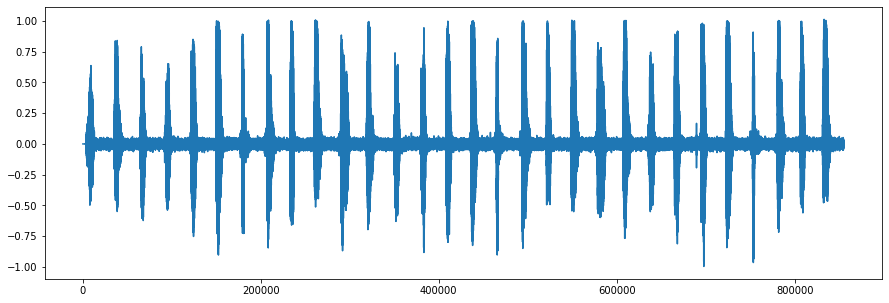

In [ ]:
from IPython.display import Audio
import matplotlib.pyplot as plt

key = list(uploaded.keys())[0]
path = '/content/%s' % key
print(path)

x, fs = librosa.core.load(path)

display(Audio(x,rate=fs))
plt.figure(figsize=(15,5))
plt.plot(x)
plt.show()

Split: [4096:12800] (8704)


Split: [34816:43520] (8704)


Split: [65024:71168] (6144)


Split: [92672:99328] (6656)


Split: [120832:128512] (7680)


Split: [149504:157696] (8192)


Split: [178176:182784] (4608)


Split: [206336:215040] (8704)


Split: [232448:238592] (6144)


Split: [259072:268800] (9728)


Split: [289280:300032] (10752)


Split: [318464:327168] (8704)


Split: [350208:356864] (6656)


Split: [378880:386560] (7680)


Split: [407552:414720] (7168)


Split: [435712:443904] (8192)


Split: [463872:468480] (4608)


Split: [492544:502272] (9728)


Split: [520192:526848] (6656)


Split: [547840:557568] (9728)


Split: [577536:588288] (10752)


Split: [606208:615936] (9728)


Split: [635904:643072] (7168)


Split: [664064:671744] (7680)


Split: [693760:701440] (7680)


Split: [721920:730624] (8704)


Split: [752128:756224] (4096)


Split: [779776:788992] (9216)


Split: [805888:812032] (6144)


Split: [830976:840192] (9216)


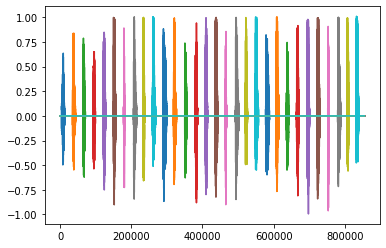

In [ ]:
ignore_length = 3100
split_points = librosa.effects.split(x,top_db=18)
audios = []

for split in split_points:
    xplot = np.zeros_like(x)
    xplot[split[0]:split[1]] = x[split[0]:split[1]]
    length = split[1] - split[0]
    print("Split: [%d:%d] (%d)" % (split[0], split[1], length))
    plt.plot(xplot)
    audio = x[split[0]:split[1]]
    if (length < ignore_length):
      print("Se ignora este audio por que es muy corto")
    else:
        audios.append(audio)
    display(Audio(audio, rate=fs))

if len(audios) % 10 != 0:
    raise Exception("Cantidad de audios detectado no es multiplo de 10, probable que haya que ajustar `top_db` y/o `ignore_length`!")

In [ ]:
data = []
columns = []
try:
    import soundfile as sf
except ImportError as error:
    import os
    os.system('pip install soundfile')
    import soundfile as sf

for i in range(len(audios)):
    audio = audios[i]
    sf.write('temp.wav', audio, fs)
    number = i % 10
    feat, names = calculate_features('temp.wav')
    data.append(np.append(feat, [number, key]))
    columns = names + ['target', 'key']

dataset = pd.DataFrame(data, columns = columns)
dataset.to_csv('/content/%s.csv' % key, header=True, index=True)
dataset.head()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,key
0,-236.94913079357548,191.2937819243726,-33.676390158316714,28.528073730573176,15.590618551073533,-26.297717190201595,-12.089993841167512,22.125864418486398,-30.357360824930456,-8.676643188308152,-7.708008337309967,-21.731173159847494,0.14361190092232493,45.16955678570006,13.089623606381327,25.709927245328487,21.406644395559194,23.86131988501087,11.468803356243086,6.123887843118991,16.57804680971037,14.649069392142945,7.447275511679586,7.6652516435852975,9.02497094865324,0.0506022811150537,-1.4035469120712625,1.711292075372034,2.097117558970512,-3.0527033796736696,-1.9807451835375804,1.047979566169875,-0.07212121432921743,-0.48943000084860216,0.34970448151941097,0.35825385514568964,1.318755175241911,0.44267504296441007,-0.001539142254520865,18.892310467728688,8.23706569786414,11.920959826489021,10.895131668897891,7.237102981756717,7.10258700143124,5.586853212669433,7.521273084303978,6.81214398001205,5.368268079360414,5.696431737998958,5.517511652262357,0.022435058882625203,-1.7785242687414602,0.061196739915308385,1.3337204780865284,0.2788506371026702,-0.01512172505133802,0.1574875303282397,0.18806271906254934,-0.31694484449995175,0.6683716355466955,0.06340337385836636,0.27191817041648236,0.7723722418813119,-0.002407460007816553,11.312900063266609,8.262565912550604,11.476693816486632,7.384074166152209,5.847250883064091,5.983747844849991,6.761778960667674,5.596842976961752,5.617602702954426,6.16276969886449,6.185935203029568,5.418877586126227,0.013066804143233877,0,ventilador.wav
1,-196.55387528978346,187.161623420244,-57.637310270718935,39.985584517000184,-13.57995023326657,-16.144617538330298,4.7325433317128835,9.28361474346739,-31.112002852986823,-6.079352214932896,5.0781605776880365,-18.981117976008125,0.15936043134166133,63.3475631519564,17.427420780574906,29.590784860759392,10.657431295970927,27.619448183243218,17.373737874793644,6.697387066241732,7.526384522516076,10.704308822904048,4.57831990426152,9.540070071442203,8.384530928736792,0.08201584096720678,-0.33298593993318676,-1.515896373414725,-1.2831722805645593,0.2801604346127276,0.5359805670724431,0.8556922001300705,0.7099232835465394,0.1109106172146287,-0.0211825668108831,0.23776055877663924,0.5072273132809976,-0.18625396253416035,-0.00373418366207796,25.66667334819643,8.928316331170505,13.372355046533425,5.043548099193184,10.919778581520308,8.694040835585355,5.13158845407323,4.565824524841597,5.621793355974816,3.7705464592205598,4.319805877527507,5.460397161230541,0.02794525977724392,-3.375800798156135,-0.059104310754758416,2.3392118097469594,-0.49239482548561875,0.6521911655501549,1.2755543327852712,-0.6055282060135807,-0.15598918448574978,0.9235041554484269,-0.1438403520710961,0.42093278671099665,0.9690071911085735,-0.0012985160574316978,11.924644849966908,9.386983377107375,6.29656714563047,4.88971165796025,6.51950745986166,7.129705006121468,4.54222536773097,5.053808840536891,4.96569086741601,5.512705362821542,3.886004604321805,5.929135715548666,0.012818142466617746,1,ventilador.wav
2,